In [1]:
from scipy import ndimage
from scipy.signal import convolve2d
from sklearn import cluster
import numpy as np
import matplotlib.pyplot as plt
import cv2
np.set_printoptions(suppress=True,
   formatter={'float_kind':'{:0.2f}'.format}) 

In [2]:
def canny_edge_detection(image, sigma, low, high):
    img = image
    gaussian_2D = gaussian_kernel(5,sigma)
    gaussian_1D_x , gaussian_1D_y = seperate_2Dkernel(gaussian_2D)
    img = convolve1d(img,gaussian_1D_x)
    img = convolve1d(img,gaussian_1D_y,'y')
    plt.imshow(img,cmap="gray")
    plt.title("1D gaussian")
    plt.savefig("1Dgaussian.png")
    plt.show()
    sobel_x = sobel_filters(img,'x')
    sobel_y = sobel_filters(img,'y')
    magnitude = np.hypot(sobel_x,sobel_y)
    plt.imshow(magnitude,cmap="gray")
    plt.title("After sobel")
    plt.savefig("sobel.png")
    plt.show()
    theta = np.arctan2(-sobel_y, sobel_x)
    img = non_max_suppression1(magnitude,theta)
    plt.imshow(img,cmap="gray")
    plt.title("after supression")
    plt.savefig("supression.png")
    plt.show()
    res = threshold(img,low,high)
    img = hysteresis(res)
    return img

In [3]:
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

In [4]:
def sobel_filters(img,direction = 'x'):
    
    if direction == 'x':
        x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
        convol_img = convolve2d(img,x,mode='same')
        convol_img = convol_img/convol_img.max()*255
    else:
        y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
        convol_img = convolve2d(img,y,mode='same')
        convol_img = convol_img/convol_img.max()*255
    return convol_img

In [5]:
def non_max_suppression1(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = np.rad2deg(D)
    angle[angle < 0] += 180
    for i in range(1,M-1):
        for j in range(1,N-1):
                q = 255
                r = 255
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j+1]
                    r = img[i-1, j-1]
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0
        
    return Z

In [6]:
def threshold(img, lowThresh, highThresh):
    weak = 0.5
    strong = 1
    highThreshold = img.max() * highThresh;
    lowThreshold = img.max() * lowThresh;
    new_img = np.zeros(img.shape, dtype=np.int32)
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    weak_i, weak_j = np.where((lowThreshold <= img) & (img <= highThreshold))
    new_img[zeros_i, zeros_j] = 0
    new_img[strong_i, strong_j] = strong
    new_img[weak_i, weak_j] = weak
    return new_img

In [7]:
def hysteresis(img):
    weak = 0.5
    strong = 1
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
    return img

In [8]:
def convolve1d(matrix,kernel,direction="x"):
    if direction != "x":
        matrix = np.transpose(matrix)
    m,n = matrix.shape
    new_matrix = np.zeros((m,n))
    zero = np.zeros((m,1))
    for i in range(0,len(kernel)//2):
        matrix = np.append(matrix, zero, axis=1)
        matrix = np.append(zero, matrix, axis=1)
    for i in range(0,m):
        for j in range(0,n):
            new_matrix[i][j] = np.dot(matrix[i][j:j+len(kernel)],np.transpose(kernel))
    if direction != "x":
        new_matrix = np.transpose(new_matrix)       
    return new_matrix

In [9]:
def seperate_2Dkernel(kernel):
    u,s,v = np.linalg.svd(kernel)
    x = np.dot(u * -1,np.sqrt(s))
    y = np.dot(np.sqrt(s),v * -1)
    return x,y

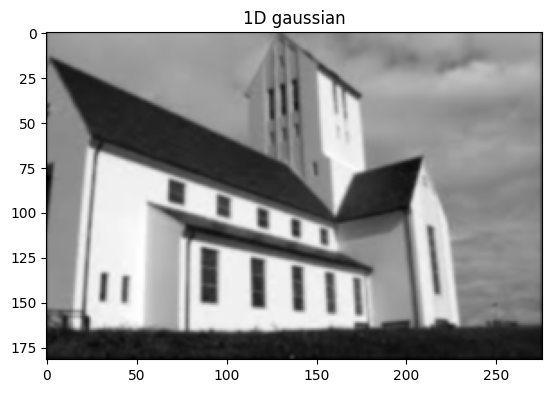

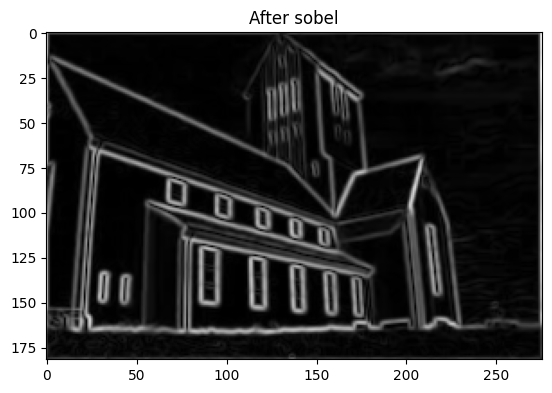

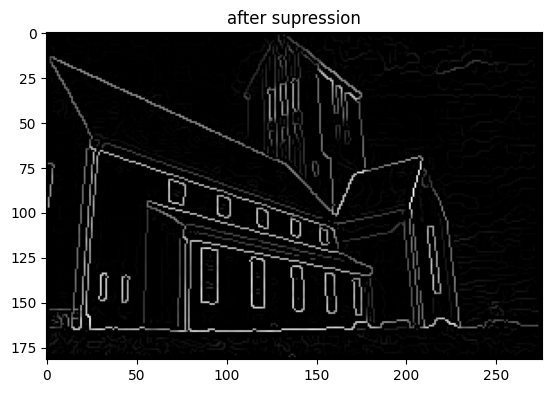

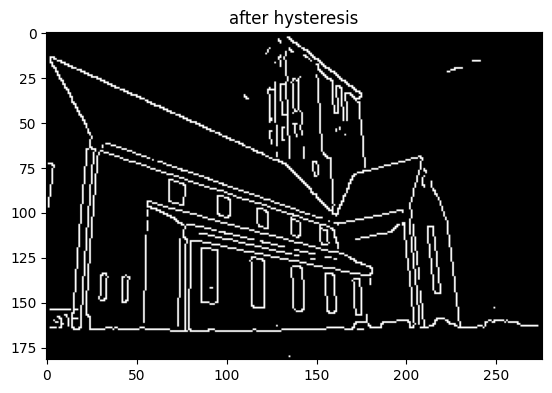

In [10]:
img = cv2.cvtColor(cv2.imread('image1.jfif'), cv2.COLOR_BGR2GRAY)
img = canny_edge_detection(img,0.9,0.1,0.2)
plt.imshow(img,cmap='gray')
plt.title("after hysteresis")
plt.savefig("final.png")
plt.show()